# This notebook tests ANP-RNN + MC Dropout 

Ideally a NP should learn uncertainty, but it may also be overconfident. In neural network monte carlo dropout often provides a more robust uncertainty. Here I compare it and find that the uncertainty from MCLoss improved the validation loss when added to the models estimation of uncertainty.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback
import math


In [3]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

In [5]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger

In [6]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [7]:
df_train, df_test = get_smartmeter_df()

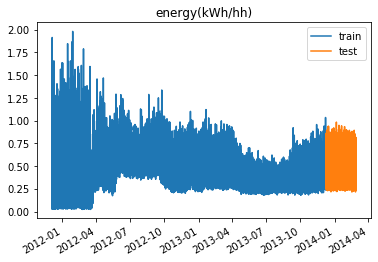

In [8]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Train helpers

In [47]:
PERCENT_TEST_EXAMPLES = 0.5
# EPOCHS = 5
DIR = Path(os.getcwd())
MODEL_DIR = DIR/ 'lightning_logs'
name = 'anp-rnn-mcdropout' # study name
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"now run `tensorboard --logdir {MODEL_DIR}`")

now run `tensorboard --logdir /media/wassname/Storage5/projects2/3ST/attentive-neural-processes/lightning_logs


In [48]:
def main(trial, train=True):    
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name="anp-rnn", version=trial.number)

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        gradient_clip_val=trial.params["grad_clip"],
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.params['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    model = LatentModelPL(trial.params)
    if train:
        trainer.fit(model)
    
    return model, trainer


def add_sugg(trial):
    
    trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    trial.suggest_categorical("hidden_dim", [8*2**i for i in range(6)])
    trial.suggest_categorical("latent_dim", [8*2**i for i in range(6)])
    
    trial.suggest_int("attention_layers", 1, 4)
    trial.suggest_categorical("n_latent_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_det_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_decoder_layers", [1, 2, 4, 8])

    trial.suggest_categorical("dropout", [0, 0.2, 0.5])
    trial.suggest_categorical("attention_dropout", [0, 0.2, 0.5])

    trial.suggest_categorical(
        "latent_enc_self_attn_type", ['uniform', 'multihead', 'ptmultihead']
    )
    trial.suggest_categorical("det_enc_self_attn_type",  ['uniform', 'multihead', 'ptmultihead'])
    trial.suggest_categorical("det_enc_cross_attn_type", ['uniform', 'multihead', 'ptmultihead'])

    trial.suggest_categorical("batchnorm", [False, True])
    trial.suggest_categorical("use_self_attn", [False, True])
    trial.suggest_categorical("use_lvar", [False, True])
    trial.suggest_categorical("use_deterministic_path", [False, True])
    trial.suggest_categorical("use_rnn", [True, False])

    # training specific (for this model)
    trial.suggest_uniform("min_std", 0.005, 0.005)
    trial.suggest_int("grad_clip", 40, 40)
    trial.suggest_int("num_context", 24 * 4, 24 * 4)
    trial.suggest_int("num_extra_target", 24*4, 24*4)
    trial.suggest_int("max_nb_epochs", 10, 10)
    trial.suggest_int("num_workers", 3, 3)
    trial.suggest_int("batch_size", 16, 16)
    trial.suggest_int("num_heads", 8, 8)

    trial.suggest_int("x_dim", 17, 17)
    trial.suggest_int("y_dim", 1, 1)
    trial.suggest_int("vis_i", 670, 670)
    
    trial.suggest_categorical("context_in_target", [True, True])
    
    return trial

def add_trial_number(trial, dir_name):
    # Optuna needs a number for each trial. For manual trials lets go -1, -2, etc
    versions = [int(s.stem.split('_')[1]) for s in (MODEL_DIR/name).glob('*')] + [0]
    trial.number = min(versions) - 1
    return trial

def objective(trial):
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    
    trial = add_sugg(trial)
    
    print('trial', trial.number, 'params', trial.params)
    
    
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    model, trainer = main(trial)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    
    return model.logger.metrics[-1]['val_loss']


In [49]:
from typing import Callable

def convert_layers(model:nn.Module, original:nn.Module, value: bool):
    """
    Turn dropout on
    """
    for child_name, child in model.named_children():
        if isinstance(child, original):
#             print(child, 'from', child.training, 'to', value)
            child.train(value)
            
        else:
            convert_layers(child, original, value)

In [50]:
from src.plot import plot_rows


def eval_mc(model, loader, i):
    device = next(model.parameters()).device

    data = loader.collate_fn([loader.dataset[i]], sample=False)
    data = [d.to(device) for d in data]
    context_x, context_y, target_x_extra, target_y_extra = data
    target_x = target_x_extra
    target_y = target_y_extra

    # do MCDropout estimation
    model.eval()
    convert_layers(model, torch.nn.modules.dropout.Dropout2d, True)
    model.model._lstm.train()

    y_preds = []
    y_stds = []
    with torch.no_grad():
        for i in range(n_mcdropout):
            y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
            y_std = extra['dist'].scale
            y_preds.append(y_pred)
            y_stds.append(y_std)
    y_stds = torch.stack(y_stds)
    y_preds = torch.stack(y_preds)


    mean = y_preds.mean(0)
    sigma = y_stds.mean(0)

    dist = torch.distributions.Normal(mean, sigma)
    log_p = dist.log_prob(target_y).mean(-1)
    loss_mc = - log_p


    # Try without MCDropout
    model.eval()
    with torch.no_grad():
#         y_pred, kl, loss_test, loss_mse, y_std 
        y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
        y_std = extra['dist'].scale
    

    dist = torch.distributions.Normal(y_pred, y_std)
    log_p = dist.log_prob(target_y).mean(-1)
    loss = - log_p   

    return loss_mc.cpu(), loss.cpu()

In [51]:

def init_random_seed(seed):
    # https://pytorch.org/docs/stable/notes/randomness.html
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    


# Default params

In [52]:
default_params = {
 'attention_dropout': 0,
 'attention_layers': 2,
 'batch_size': 16,
 'batchnorm': False,
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'uniform',
 'dropout': 0,
 'grad_clip': 40,
 'hidden_dim': 128,
 'latent_dim': 128,
 'latent_enc_self_attn_type': 'uniform',
 'learning_rate': 0.002,
 'max_nb_epochs': 10,
 'min_std': 0.005,
 'n_decoder_layers': 4,
 'n_det_encoder_layers': 4,
 'n_latent_encoder_layers': 2,
 'num_context': 24*4,
 'num_extra_target': 24*4,
 'num_heads': 8,
 'num_workers': 3,
 'use_deterministic_path': True,
 'use_lvar': True,
 'use_self_attn': True,
 'vis_i': '670',
 'x_dim': 17,
 'y_dim': 1,
 'use_rnn': False,
 'context_in_target': True
}

# Train ANP-RNN

# ANP-RNN 2

INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0  | model                                                                     | LatentModel          | 3 M   
1  | model._lstm                                                               | LSTM                 | 807 K 
2  | model._latent_encoder                                                     | LatentEncoder        | 328 K 
3  | model._latent_encoder._encoder                                            | BatchMLP             | 131 K 
4  | model._latent_encoder._encoder.initial                                    | NPBlockRelu2d        | 65 K  
5  | model._latent_encoder._encoder.initial.linear                             | Linear               | 65 K  
6  | model._latent_encoder._enco

step val 0, {'val_loss': '1.0510647296905518', 'val/kl': '0.500446081161499', 'val/std': '1.011029839515686', 'val/mse': '0.321998655796051'} {}


step val 2194, {'val_loss': '-0.13158796727657318', 'val/kl': '0.00033035798696801066', 'val/std': '0.21403183043003082', 'val/mse': '0.032815106213092804'} {'train_loss': tensor(16.5981, device='cuda:0'), 'train/kl': tensor(0.0179, device='cuda:0'), 'train/std': tensor(0.4463, device='cuda:0'), 'train/mse': tensor(0.1485, device='cuda:0')}


step val 4389, {'val_loss': '-0.4325900673866272', 'val/kl': '9.704002877697349e-05', 'val/std': '0.09763659536838531', 'val/mse': '0.014293229207396507'} {'train_loss': tensor(-0.2103, device='cuda:0'), 'train/kl': tensor(0.0009, device='cuda:0'), 'train/std': tensor(0.1743, device='cuda:0'), 'train/mse': tensor(0.0344, device='cuda:0')}


step val 6584, {'val_loss': '-0.43620601296424866', 'val/kl': '4.939149948768318e-05', 'val/std': '0.09694259613752365', 'val/mse': '0.013617178425192833'} {'train_loss': tensor(-0.3606, device='cuda:0'), 'train/kl': tensor(0.0005, device='cuda:0'), 'train/std': tensor(0.1432, device='cuda:0'), 'train/mse': tensor(0.0260, device='cuda:0')}


step val 8779, {'val_loss': '-0.42683538794517517', 'val/kl': '8.107969915727153e-05', 'val/std': '0.09468298405408859', 'val/mse': '0.0107091274112463'} {'train_loss': tensor(-0.4410, device='cuda:0'), 'train/kl': tensor(0.0004, device='cuda:0'), 'train/std': tensor(0.1285, device='cuda:0'), 'train/mse': tensor(0.0230, device='cuda:0')}


step val 10974, {'val_loss': '-0.5034099817276001', 'val/kl': '3.636208930402063e-05', 'val/std': '0.0672297552227974', 'val/mse': '0.00938461348414421'} {'train_loss': tensor(-0.5030, device='cuda:0'), 'train/kl': tensor(0.0003, device='cuda:0'), 'train/std': tensor(0.1138, device='cuda:0'), 'train/mse': tensor(0.0200, device='cuda:0')}


step val 13169, {'val_loss': '-0.24954310059547424', 'val/kl': '3.8109676097519696e-05', 'val/std': '0.060545068234205246', 'val/mse': '0.01272621750831604'} {'train_loss': tensor(-0.5629, device='cuda:0'), 'train/kl': tensor(0.0001, device='cuda:0'), 'train/std': tensor(0.1040, device='cuda:0'), 'train/mse': tensor(0.0180, device='cuda:0')}


step val 15364, {'val_loss': '-0.11352463811635971', 'val/kl': '1.6889993275981396e-05', 'val/std': '0.05332550033926964', 'val/mse': '0.013464201241731644'} {'train_loss': tensor(-0.6062, device='cuda:0'), 'train/kl': tensor(9.2420e-05, device='cuda:0'), 'train/std': tensor(0.0985, device='cuda:0'), 'train/mse': tensor(0.0169, device='cuda:0')}
Epoch     6: reducing learning rate of group 0 to 2.0000e-04.


step val 17559, {'val_loss': '-0.04702010378241539', 'val/kl': '1.287278973904904e-05', 'val/std': '0.04811198264360428', 'val/mse': '0.012275541201233864'} {'train_loss': tensor(-0.6955, device='cuda:0'), 'train/kl': tensor(5.2590e-05, device='cuda:0'), 'train/std': tensor(0.0835, device='cuda:0'), 'train/mse': tensor(0.0139, device='cuda:0')}
INFO:root:Epoch 00008: early stopping



step val 17560, {'val_loss': '-0.04702010378241539', 'val/kl': '1.287278973904904e-05', 'val/std': '0.04811198264360428', 'val/mse': '0.012275541201233864'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------

1 None



Lower is better, validation loss
MCDropout: -1.32
Inference: -0.14
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0  | model                                                                     | LatentModel          | 3 M   
1  | model._lstm                                                               | LSTM                 | 807 K 
2  | model._latent_encoder                                                     | LatentEncoder        | 328 K 
3  | model._latent_encoder._encoder                                            | BatchMLP             | 131 K 
4  | model._latent_encoder._encoder.initial                                    | NPBlockRelu2d        | 65 K  
5  | model._latent_encoder._encoder.initial.linear                         

step val 0, {'val_loss': '1.0469273328781128', 'val/kl': '0.5012975931167603', 'val/std': '1.0240424871444702', 'val/mse': '0.2834925353527069'} {}


step val 2194, {'val_loss': '-0.530510663986206', 'val/kl': '0.000497261353302747', 'val/std': '0.10500864684581757', 'val/mse': '0.008976762183010578'} {'train_loss': tensor(-0.1966, device='cuda:0'), 'train/kl': tensor(0.0111, device='cuda:0'), 'train/std': tensor(0.2003, device='cuda:0'), 'train/mse': tensor(0.0401, device='cuda:0')}


step val 4389, {'val_loss': '-0.5772886276245117', 'val/kl': '0.00011175952386111021', 'val/std': '0.09931007772684097', 'val/mse': '0.007692516781389713'} {'train_loss': tensor(-0.4069, device='cuda:0'), 'train/kl': tensor(0.0007, device='cuda:0'), 'train/std': tensor(0.1353, device='cuda:0'), 'train/mse': tensor(0.0239, device='cuda:0')}


step val 6584, {'val_loss': '-0.5756369233131409', 'val/kl': '6.505264900624752e-05', 'val/std': '0.06530915945768356', 'val/mse': '0.007986452430486679'} {'train_loss': tensor(-0.4907, device='cuda:0'), 'train/kl': tensor(0.0003, device='cuda:0'), 'train/std': tensor(0.1155, device='cuda:0'), 'train/mse': tensor(0.0198, device='cuda:0')}


step val 8779, {'val_loss': '-0.5241847634315491', 'val/kl': '4.0910555981099606e-05', 'val/std': '0.06427723169326782', 'val/mse': '0.01057453267276287'} {'train_loss': tensor(-0.5611, device='cuda:0'), 'train/kl': tensor(0.0002, device='cuda:0'), 'train/std': tensor(0.1037, device='cuda:0'), 'train/mse': tensor(0.0176, device='cuda:0')}
Epoch     3: reducing learning rate of group 0 to 2.0000e-04.


step val 10974, {'val_loss': '-0.5098873972892761', 'val/kl': '4.259546039975248e-05', 'val/std': '0.054850272834300995', 'val/mse': '0.007577850017696619'} {'train_loss': tensor(-0.6559, device='cuda:0'), 'train/kl': tensor(0.0001, device='cuda:0'), 'train/std': tensor(0.0854, device='cuda:0'), 'train/mse': tensor(0.0144, device='cuda:0')}
INFO:root:Epoch 00005: early stopping



step val 10975, {'val_loss': '-0.5098873972892761', 'val/kl': '4.259546039975248e-05', 'val/std': '0.054850272834300995', 'val/mse': '0.007577850017696619'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------

10 None



Lower is better, validation loss
MCDropout: -1.35
Inference: -0.98
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0  | model                                                                     | LatentModel          | 3 M   
1  | model._lstm                                                               | LSTM                 | 807 K 
2  | model._latent_encoder                                                     | LatentEncoder        | 328 K 
3  | model._latent_encoder._encoder                                            | BatchMLP             | 131 K 
4  | model._latent_encoder._encoder.initial                                    | NPBlockRelu2d        | 65 K  
5  | model._latent_encoder._encoder.initial.linear                         

step val 0, {'val_loss': '1.012698769569397', 'val/kl': '0.4999396800994873', 'val/std': '0.9445148706436157', 'val/mse': '0.2685103118419647'} {}


step val 2194, {'val_loss': '-0.5518873333930969', 'val/kl': '0.0005956587265245616', 'val/std': '0.09785215556621552', 'val/mse': '0.009662301279604435'} {'train_loss': tensor(-0.1527, device='cuda:0'), 'train/kl': tensor(0.0142, device='cuda:0'), 'train/std': tensor(0.1988, device='cuda:0'), 'train/mse': tensor(0.0387, device='cuda:0')}


step val 4389, {'val_loss': '-0.6637553572654724', 'val/kl': '0.00019845462520606816', 'val/std': '0.08266466856002808', 'val/mse': '0.00628650700673461'} {'train_loss': tensor(-0.4334, device='cuda:0'), 'train/kl': tensor(0.0008, device='cuda:0'), 'train/std': tensor(0.1298, device='cuda:0'), 'train/mse': tensor(0.0225, device='cuda:0')}


step val 6584, {'val_loss': '-0.617118775844574', 'val/kl': '0.00016509862325619906', 'val/std': '0.07126334309577942', 'val/mse': '0.007818297483026981'} {'train_loss': tensor(-0.5136, device='cuda:0'), 'train/kl': tensor(0.0006, device='cuda:0'), 'train/std': tensor(0.1137, device='cuda:0'), 'train/mse': tensor(0.0194, device='cuda:0')}


step val 8779, {'val_loss': '-0.5473427176475525', 'val/kl': '0.0005901139229536057', 'val/std': '0.0750400647521019', 'val/mse': '0.0075106206350028515'} {'train_loss': tensor(-0.5703, device='cuda:0'), 'train/kl': tensor(0.0002, device='cuda:0'), 'train/std': tensor(0.1025, device='cuda:0'), 'train/mse': tensor(0.0174, device='cuda:0')}
Epoch     3: reducing learning rate of group 0 to 2.0000e-04.


step val 10974, {'val_loss': '-0.43197354674339294', 'val/kl': '0.00011243290646234527', 'val/std': '0.04987134784460068', 'val/mse': '0.008202551864087582'} {'train_loss': tensor(-0.6803, device='cuda:0'), 'train/kl': tensor(0.0002, device='cuda:0'), 'train/std': tensor(0.0856, device='cuda:0'), 'train/mse': tensor(0.0145, device='cuda:0')}
INFO:root:Epoch 00005: early stopping



step val 10975, {'val_loss': '-0.43197354674339294', 'val/kl': '0.00011243290646234527', 'val/std': '0.04987134784460068', 'val/mse': '0.008202551864087582'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------

20 None



Lower is better, validation loss
MCDropout: -1.42
Inference: -0.83
INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
   | Name                                                                      | Type                 | Params
---------------------------------------------------------------------------------------------------------------
0  | model                                                                     | LatentModel          | 3 M   
1  | model._lstm                                                               | LSTM                 | 807 K 
2  | model._latent_encoder                                                     | LatentEncoder        | 328 K 
3  | model._latent_encoder._encoder                                            | BatchMLP             | 131 K 
4  | model._latent_encoder._encoder.initial                                    | NPBlockRelu2d        | 65 K  
5  | model._latent_encoder._encoder.initial.linear                         

step val 0, {'val_loss': '1.042716145515442', 'val/kl': '0.5014282464981079', 'val/std': '0.9882966876029968', 'val/mse': '0.3160552680492401'} {}


step val 2194, {'val_loss': '-0.505888044834137', 'val/kl': '0.0014137973776087165', 'val/std': '0.10111173987388611', 'val/mse': '0.009526045061647892'} {'train_loss': tensor(-0.0562, device='cuda:0'), 'train/kl': tensor(0.0195, device='cuda:0'), 'train/std': tensor(0.2750, device='cuda:0'), 'train/mse': tensor(0.0643, device='cuda:0')}


step val 4389, {'val_loss': '-0.557587206363678', 'val/kl': '0.000489492085762322', 'val/std': '0.09902777522802353', 'val/mse': '0.008159227669239044'} {'train_loss': tensor(-0.3625, device='cuda:0'), 'train/kl': tensor(0.0009, device='cuda:0'), 'train/std': tensor(0.1431, device='cuda:0'), 'train/mse': tensor(0.0255, device='cuda:0')}


step val 6584, {'val_loss': '-0.5964198112487793', 'val/kl': '0.0002973293012473732', 'val/std': '0.08056288957595825', 'val/mse': '0.006397944409400225'} {'train_loss': tensor(-0.4486, device='cuda:0'), 'train/kl': tensor(0.0005, device='cuda:0'), 'train/std': tensor(0.1250, device='cuda:0'), 'train/mse': tensor(0.0218, device='cuda:0')}


step val 8779, {'val_loss': '-0.5422907471656799', 'val/kl': '0.00012692170275840908', 'val/std': '0.06759794056415558', 'val/mse': '0.008814225904643536'} {'train_loss': tensor(-0.5096, device='cuda:0'), 'train/kl': tensor(0.0003, device='cuda:0'), 'train/std': tensor(0.1129, device='cuda:0'), 'train/mse': tensor(0.0194, device='cuda:0')}


step val 10974, {'val_loss': '-0.5207902789115906', 'val/kl': '0.0001391253317706287', 'val/std': '0.06595303863286972', 'val/mse': '0.008053481578826904'} {'train_loss': tensor(-0.5552, device='cuda:0'), 'train/kl': tensor(0.0002, device='cuda:0'), 'train/std': tensor(0.1058, device='cuda:0'), 'train/mse': tensor(0.0182, device='cuda:0')}
Epoch     4: reducing learning rate of group 0 to 2.0000e-04.


step val 13169, {'val_loss': '-0.48278191685676575', 'val/kl': '6.692813622066751e-05', 'val/std': '0.05369281396269798', 'val/mse': '0.007348351180553436'} {'train_loss': tensor(-0.6591, device='cuda:0'), 'train/kl': tensor(0.0001, device='cuda:0'), 'train/std': tensor(0.0866, device='cuda:0'), 'train/mse': tensor(0.0148, device='cuda:0')}
INFO:root:Epoch 00006: early stopping



step val 13170, {'val_loss': '-0.48278191685676575', 'val/kl': '6.692813622066751e-05', 'val/std': '0.05369281396269798', 'val/mse': '0.007348351180553436'} {}
----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------

100 None



Lower is better, validation loss
MCDropout: -1.36
Inference: -0.98



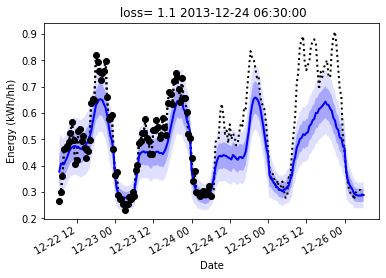

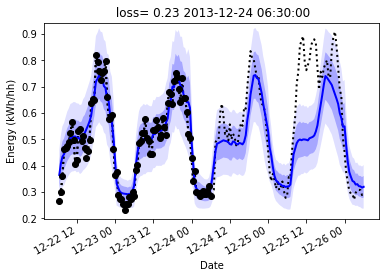

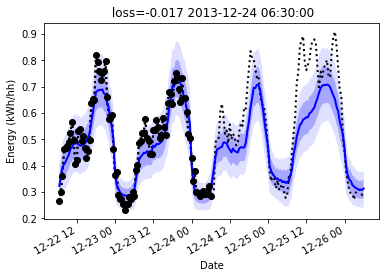

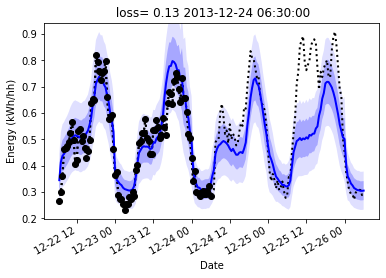

In [53]:
name = 'anp-rnn-mcdropout'
params =default_params.copy()
params.update({
 'det_enc_cross_attn_type': 'ptmultihead',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
 'dropout': 0.2,
 'hidden_dim': 128*2,
 'latent_dim': 128*2, 
 'use_deterministic_path': False,
 'use_rnn': True,
 'vis_i': 670
})
n_mcdropout=10
n_steps=600
vis_i=670
results = []

for seed in tqdm([1, 10, 20, 100], desc='seeds'):
    init_random_seed(seed)

    trial = optuna.trial.FixedTrial(params)
    trial = add_sugg(trial)
    trial = add_trial_number(trial, MODEL_DIR/name)


    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

    logger = DictLogger(MODEL_DIR, name="anp", version=trial.number)

    trainer = pl.Trainer(
        gradient_clip_val=trial.params["grad_clip"],
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.params['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=True
    )
    model = LatentModelPL(trial.params)

    trainer.fit(model)

    # plot, main metric
#     loader = model.val_dataloader()
    
    plot_from_loader(loader, model, i=vis_i)

    
    # Testing will load best checkpoint
    print(seed, trainer.test(model))

    
    # MCDropout

    loader = model.val_dataloader()
    device = next(model.parameters()).device
    inds = np.random.randint(0, len(loader.dataset), n_steps)

    losses_mc = []
    losses = []
    for i in tqdm(inds, desc='MCDropout eval'):
        loss_mc, loss = eval_mc(model, loader, i)
        losses_mc.append(loss_mc)
        losses.append(loss)

    loss_mc = torch.stack(losses_mc).mean().item()
    loss = torch.stack(losses).mean().item()
    
    results.append(dict(seed=seed, loss=loss, loss_mc=loss_mc, inds=inds))
    print(f"seed={seed}. Lower is better, validation loss")
    print(f"MCDropout: {loss_mc:2.2f}")
    print(f"Inference: {loss:2.2f}")

In [66]:
df_result = pd.DataFrame(results)
df_result['loss'] = df_result['loss'].astype(float)
df_result['loss_mc'] = df_result['loss_mc'].astype(float)
print('lower is better')
df_result

lower is better


,seed,loss,loss_mc,inds
0,1,-0.136217,-1.320583,"[1436, 3115, 3540, 2502, 3041, 3356, 3068, 148..."
1,10,-0.982833,-1.346300,"[3525, 1264, 1046, 3256, 2701, 2319, 1883, 316..."
2,20,-0.826995,-1.417526,"[1674, 3151, 1009, 264, 1051, 822, 2621, 1645,..."
3,100,-0.983974,-1.364665,"[2840, 3155, 3006, 2139, 1884, 1476, 1654, 133..."


# MCDropout test

https://towardsdatascience.com/bayesian-deep-learning-with-fastai-how-not-to-be-uncertain-about-your-uncertainty-6a99d1aa686e

We will apply mcdropout by:
- replacing dropout with a class that will still be on during test
- doing multiple inference

In [76]:
from src.plot import plot_rows
loader = model.val_dataloader()
device = next(model.parameters()).device

# Get data
i = 670
data = loader.collate_fn([loader.dataset[i]], sample=False)
data = [d.to(device) for d in data]
context_x, context_y, target_x_extra, target_y_extra = data
target_x = target_x_extra
target_y = target_y_extra

# for plotting
x_rows, y_rows = loader.dataset.get_rows(i)
max_num_context = context_x.shape[1]
y_context_rows = y_rows[:max_num_context]
y_target_extra_rows = y_rows[max_num_context:]
x_context_rows = x_rows[:max_num_context]
x_target_extra_rows = x_rows[max_num_context:]
dt = y_target_extra_rows.index[0]
y_target_rows = y_rows

In [77]:
# do MCDropout estimation
model.eval()
convert_layers(model, torch.nn.modules.dropout.Dropout2d, True)
model.model._lstm.train()

y_preds = []
y_stds = []
with torch.no_grad():
    for i in range(10):
        y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
        y_std = extra['dist'].scale
        y_preds.append(y_pred.cpu().numpy())
        y_stds.append(y_std.cpu().numpy())

y_stds = np.stack(y_stds)
y_preds = np.stack(y_preds)


In [78]:
# Lets add variation to std, since it it's unsure.. std should be higher. Although this is small
# When it's unsure of the mean, we will also add that, this is large
# This is just a quick and dirty uncalibrated one sure, we could use
y_std = y_stds.mean(0) + y_stds.std(0) + y_preds.std(0)
y_std = y_preds.std(0)
print(f'predicted std {y_stds.mean():2.2f} \nstd of std {y_stds.std(0).mean():2.2f} \nmcdropout of mean {y_preds.std(0).mean():2.2f}')
y_pred = y_preds.mean(0)

predicted std 0.08 
std of std 0.01 
mcdropout of mean 0.04


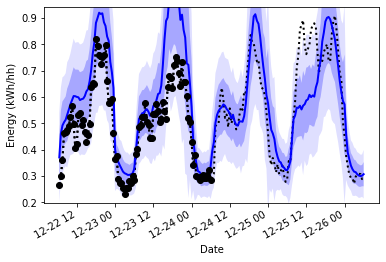

In [84]:
# with 3 sources of uncertainrty: model output and std of mean
y_std = y_stds.mean(0) + y_preds.std(0)
plot_rows(
    x_target_rows=x_target_extra_rows,
    x_context_rows=x_context_rows,
    target_y_rows=y_target_rows,
    context_y_rows=y_context_rows,
    pred_y=y_pred,
    std=y_std,
    legend=False
)
plt.show()

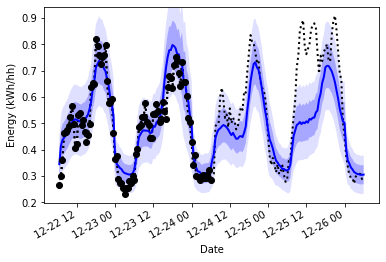

In [86]:
# Try without MCDropout
model.eval()
with torch.no_grad():
    y_pred, losses, extra = model(context_x, context_y, target_x, target_y)
    y_std = extra['dist'].scale

plot_rows(
    x_target_rows=x_target_extra_rows,
    x_context_rows=x_context_rows,
    target_y_rows=y_target_rows,
    context_y_rows=y_context_rows,
    pred_y=y_pred.detach().cpu().numpy(),
    std=y_std.detach().cpu().numpy(),
    legend=False
)
plt.show()